In [1]:
# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
# A bit of setup
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
import os
import time
import torch, torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
from train import get_dataloader
import utils.custom_transforms as cust_transforms # import RandomNoise, RandomDrop, ShufflePixels

plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

def rel_error(x, y):
  """ returns relative error """
  return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    
_DATA_FOLDER = "../../data/"
_BATCH_SIZE = 50048 # 50048 (full data) | 64
_NUM_CHANS = 3 # RGB
_FLAT_IM_SIZE = 1024 # 32 x 32 for cifar

In [39]:
def compute_eigenspectrum(this_batch):
  data_flat = torch.flatten(this_batch, 1)
  data_corr = data_flat.T @ data_flat / data_flat.shape[0]
  eigs = torch.linalg.eigvals(data_corr)
  return torch.linalg.svd(data_corr, full_matrices=False)[1]

In [43]:
def visualize_data_eigenspectrum(data, label=None, color='c', num_to_viz=None, fig=None, figsize=(15,7)):
  if fig is None: fig = plt.figure(figsize=figsize)
  if num_to_viz:
    data = data[:num_to_viz]
  plt.plot(np.log10(data), color+'--', label=label)
  return fig

### Visualize the corrupted images

In [15]:
train_loader, _ = get_dataloader(_BATCH_SIZE, add_noise=0, drop_pixels=0, data_folder=_DATA_FOLDER)
train_loader_1em1, _ = get_dataloader(_BATCH_SIZE, add_noise=0.1, drop_pixels=0, data_folder=_DATA_FOLDER)
train_loader_1e0, _ = get_dataloader(_BATCH_SIZE, add_noise=1, drop_pixels=0, data_folder=_DATA_FOLDER)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


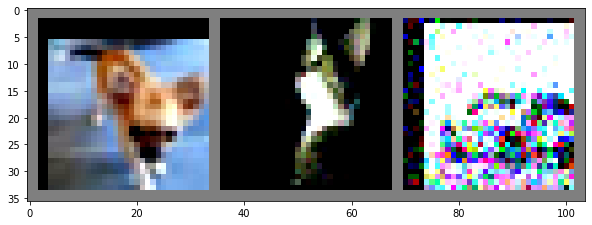

In [6]:
side_by_side_ims = torch.empty((3, _NUM_CHANS, 32, 32))
for ind, loader in enumerate([train_loader, train_loader_1em1, train_loader_1e0]):
  dataiter = iter(loader)
  images, _ = dataiter.next()
  side_by_side_ims[ind, :, :, :] = images[0, :, :, :]
  
imshow(torchvision.utils.make_grid(side_by_side_ims))

In [14]:
train_loader_30perdrop, _ = get_dataloader(_BATCH_SIZE, add_noise=0, drop_pixels=0.3, data_folder=_DATA_FOLDER)
train_loader_50perdrop, _ = get_dataloader(_BATCH_SIZE, add_noise=0, drop_pixels=0.5, data_folder=_DATA_FOLDER)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


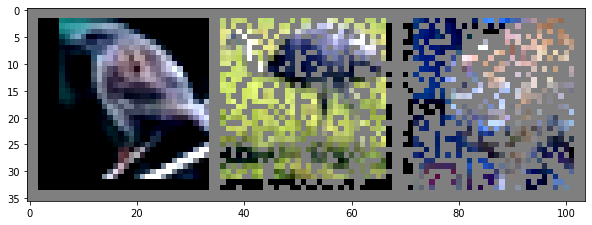

In [8]:
side_by_side_ims = torch.empty((3, _NUM_CHANS, 32, 32))
for ind, loader in enumerate([train_loader, train_loader_30perdrop, train_loader_50perdrop]):
  dataiter = iter(loader)
  images, _ = dataiter.next()
  side_by_side_ims[ind, :, :, :] = images[0, :, :, :]
  
imshow(torchvision.utils.make_grid(side_by_side_ims))

### Compute eigenspectrum

In [40]:
## Original singular values
train_loader, _ = get_dataloader(_BATCH_SIZE, add_noise=0, drop_pixels=0, data_folder=_DATA_FOLDER)
eig_accum_orig = compute_eigenspectrum(iter(train_loader).next()[0])

train_loader_1em1, _ = get_dataloader(_BATCH_SIZE, add_noise=0.1, drop_pixels=0, data_folder=_DATA_FOLDER)
eig_accum_1em1 = compute_eigenspectrum(iter(train_loader_1em1).next()[0])

train_loader_1e0, _ = get_dataloader(_BATCH_SIZE, add_noise=1, drop_pixels=0, data_folder=_DATA_FOLDER)
eig_accum_1e0 = compute_eigenspectrum(iter(train_loader_1e0).next()[0])

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [44]:
# np.save(os.path.join(os.getcwd(), 'eigs_rndnoise.out'),
#         {'orig': eig_accum_orig, '1e-1': eig_accum_1em1, '1e0': eig_accum_1e0})

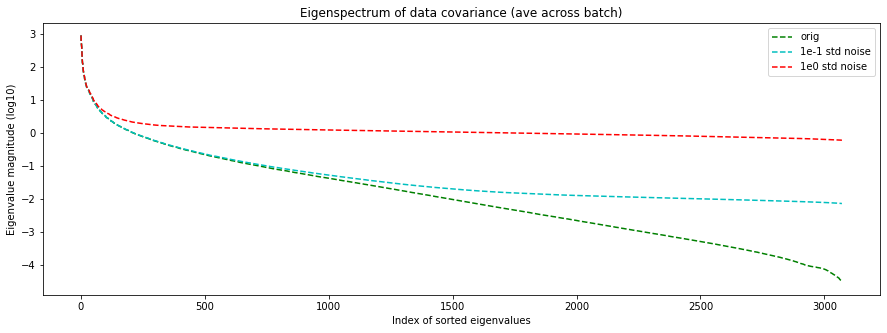

In [45]:
fig = visualize_data_eigenspectrum(eig_accum_orig, label='orig', color='g', figsize=(15,5))
fig = visualize_data_eigenspectrum(eig_accum_1em1, label='1e-1 std noise', color='c', fig=fig)
fig = visualize_data_eigenspectrum(eig_accum_1e0, label='1e0 std noise', color='r', fig=fig)
plt.legend()
plt.title('Eigenspectrum of data covariance (ave across batch)')
plt.xlabel('Index of sorted eigenvalues'); plt.ylabel('Eigenvalue magnitude (log10)')
plt.show()

In [46]:
train_loader_30perdrop, _ = get_dataloader(_BATCH_SIZE, add_noise=0, drop_pixels=0.3, data_folder=_DATA_FOLDER)
eig_accum_30perdrop = compute_eigenspectrum(iter(train_loader_30perdrop).next()[0])

train_loader_50perdrop, _ = get_dataloader(_BATCH_SIZE, add_noise=0, drop_pixels=0.5, data_folder=_DATA_FOLDER)
eig_accum_50perdrop = compute_eigenspectrum(iter(train_loader_50perdrop).next()[0])

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [47]:
# np.save(os.path.join(os.getcwd(), 'eigs_drop.out'),
#         {'orig': eig_accum_orig, '.3': eig_accum_30perdrop, '.5': eig_accum_50perdrop})

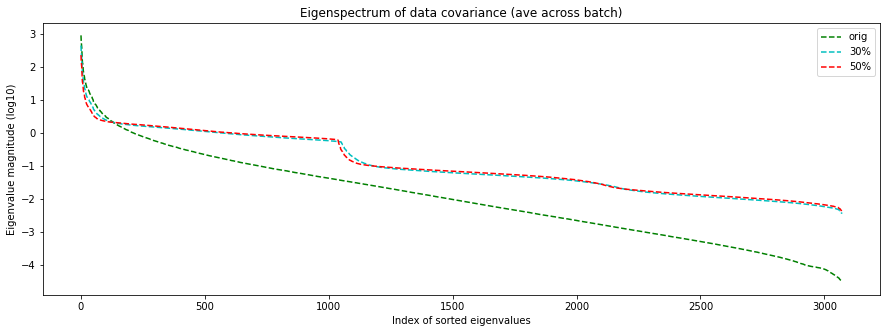

In [49]:
fig = visualize_data_eigenspectrum(eig_accum_orig, label='orig', color='g', figsize=(15,5))
fig = visualize_data_eigenspectrum(eig_accum_30perdrop, label='30%', color='c', fig=fig)
fig = visualize_data_eigenspectrum(eig_accum_50perdrop, label='50%', color='r', fig=fig)
plt.legend()
plt.title('Eigenspectrum of data covariance (ave across batch)')
plt.xlabel('Index of sorted eigenvalues'); plt.ylabel('Eigenvalue magnitude (log10)')
plt.show()

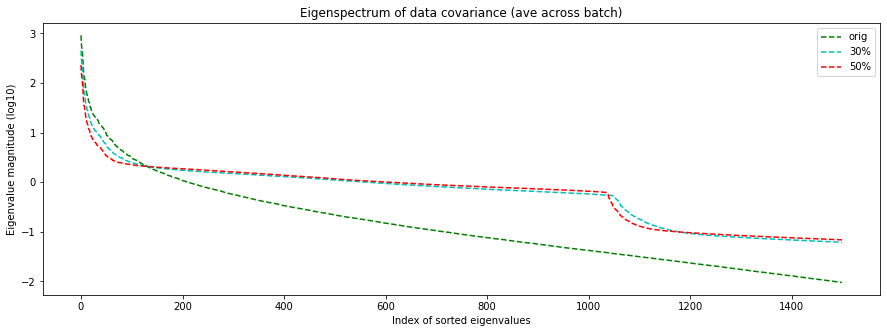

In [51]:
fig = visualize_data_eigenspectrum(eig_accum_orig, num_to_viz=1500, label='orig', color='g', figsize=(15,5))
fig = visualize_data_eigenspectrum(eig_accum_30perdrop, num_to_viz=1500, label='30%', color='c', fig=fig)
fig = visualize_data_eigenspectrum(eig_accum_50perdrop, num_to_viz=1500, label='50%', color='r', fig=fig)
plt.legend()
plt.title('Eigenspectrum of data covariance (ave across batch)')
plt.xlabel('Index of sorted eigenvalues'); plt.ylabel('Eigenvalue magnitude (log10)')
plt.show()